<a href="https://colab.research.google.com/github/mykon23/AI-2020/blob/project_phase_2/Project/Phase2/Phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MoneyBall Model

##Split Data into Training and Validation

In [59]:
!wget -O Baseball.csv https://github.com/mykon23/AI-2020/blob/master/Data/Baseball.csv?raw=True

--2020-10-13 22:05:23--  https://github.com/mykon23/AI-2020/blob/master/Data/Baseball.csv?raw=True
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mykon23/AI-2020/raw/master/Data/Baseball.csv [following]
--2020-10-13 22:05:24--  https://github.com/mykon23/AI-2020/raw/master/Data/Baseball.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Baseball.csv [following]
--2020-10-13 22:05:24--  https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Baseball.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response..

In [60]:
import pandas as pd

data = pd.read_csv('Baseball.csv')
data.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


Split the Data According to Years

In [61]:
##Get the Features of interest
features = ['OBP', 'SLG', 'BA']
output = ['RS']

In [62]:
import numpy as np

years = data['Year'].unique()
val_years = np.random.choice( years, int(0.25 * len(years)), replace=False )
print(val_years)

[1967 1978 1991 1992 1989 1971 1962 1984 2000 2010 2004]


In [63]:
##Establish the Training Set and the Validation Sets

TRAIN = pd.DataFrame()
VALID = pd.DataFrame()

for y in years:
  elem = data[ data['Year'] == y][features + output]
  if y in val_years:
    VALID = pd.concat( [VALID, elem] )
  else:
    TRAIN = pd.concat( [TRAIN, elem] )

##Training Set
TRAIN = TRAIN.to_numpy()

##Validation Set
VALID = VALID.to_numpy()

In [64]:
##Set Copies of numpy arrays
XTRAIN = np.array( TRAIN[:, :-1] )
YTRAIN = TRAIN[:, -1]

XVALID = np.array( VALID[:, :-1] )
YVALID = VALID[:, -1]

In [65]:
##Adjust the Training Data
mean = XTRAIN.mean(axis = 0)
XTRAIN -= mean
std = XTRAIN.std(axis = 0)
XTRAIN /= std

##Adjust the Validation Data
XVALID -= mean
XVALID /= std

Define Utilities for Evaluation

In [66]:
import matplotlib.pyplot as plt
from sklearn import metrics

DEFAULT_EPOCHS = 256

class PlotUtil:
  @staticmethod
  def get_learning_curve(history):
    f, ax = plt.subplots()
    ax.plot(history.history['loss'], '-', label = 'Training', color = 'blue')
    ax.plot(history.history['val_loss'], '--', label = 'Validation', color = 'orange')
    ax.set_ylabel('Loss')
    ax.set_xlabel('epoch')
    ax.set_yscale('log')
    ax.legend()
    return (f, ax)

class RegEvalUtil:
  @staticmethod
  def get_eval_metrics(y_true, y_pred):
    return { 'mse': metrics.mean_squared_error(y_true, y_pred),
            'mae': metrics.mean_absolute_error(y_true, y_pred),
            'r2': metrics.r2_score(y_true, y_pred)}


##Candidate Models and Linear Regression Model

Define the Neural Network Candidate 1

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 18)                72        
_________________________________________________________________
dense_118 (Dense)            (None, 6)                 114       
_________________________________________________________________
dense_119 (Dense)            (None, 3)                 21        
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 4         
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


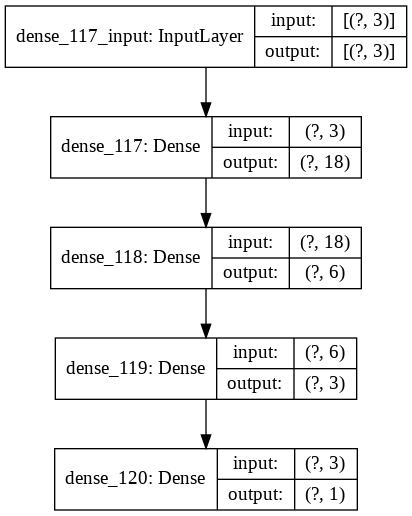

In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

runs_nn_1 = Sequential()
runs_nn_1.add( Dense(18, input_dim = len(features), activation = 'relu'))
runs_nn_1.add( Dense(6, activation='relu'))
runs_nn_1.add( Dense(3, activation = 'relu' ))
runs_nn_1.add( Dense(1, activation = 'relu' ))

runs_nn_1.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
runs_nn_1.summary()
plot_model(runs_nn_1, to_file='runs_nn_1.png', show_shapes=True)

In [154]:
##Train the Model
history_nn_1 = runs_nn_1.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      verbose = 0)

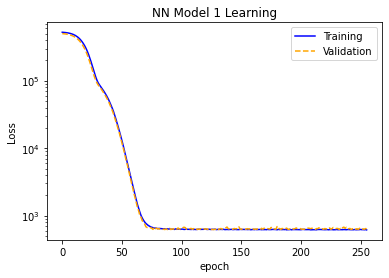

In [155]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_nn_1)
figs[1].set_title('NN Model 1 Learning')
plt.savefig('nn_1_learn_curve.png')
figs[0].show()

In [156]:
##Get the Predictions on Training and Validation
train_pred = runs_nn_1.predict(XTRAIN)
valid_pred = runs_nn_1.predict(XVALID)

nn_metrics_1 = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})
nn_metrics_1.to_csv('nn_1_metrics.csv')
nn_metrics_1.T.head()

,mse,mae,r2
train,619.538194,19.769383,0.924019
valid,640.035535,19.838126,0.927970


Define the Neural Network Candidate 2



Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 18)                72        
_________________________________________________________________
dense_122 (Dense)            (None, 9)                 171       
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 10        
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________


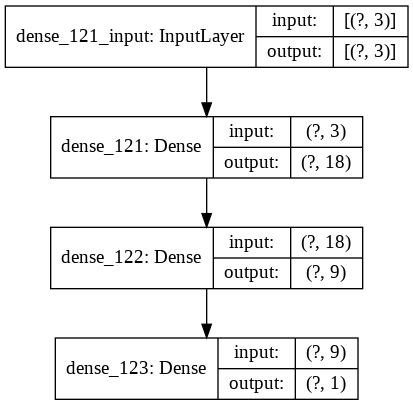

In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

runs_nn_2 = Sequential()
runs_nn_2.add( Dense(18, input_dim = len(features), activation = 'relu'))
runs_nn_2.add( Dense(9, activation = 'relu' ))
runs_nn_2.add( Dense(1, activation = 'relu' ))

runs_nn_2.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
runs_nn_2.summary()
plot_model(runs_nn_2, to_file='runs_nn_2.png', show_shapes=True)

In [158]:
##Train the Model
history_nn_2 = runs_nn_2.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      verbose = 0)

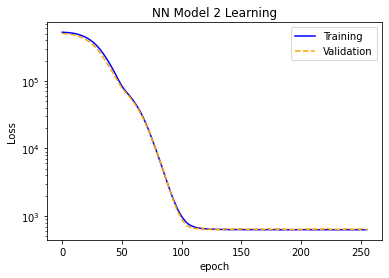

In [159]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_nn_2)
figs[1].set_title('NN Model 2 Learning')
plt.savefig('nn_2_learn_curve.png')
figs[0].show()

In [160]:
##Get the Predictions on Training and Validation
train_pred = runs_nn_2.predict(XTRAIN)
valid_pred = runs_nn_2.predict(XVALID)

nn_metrics_2 = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})
nn_metrics_2.to_csv('nn_2_metrics.csv')
nn_metrics_2.T.head()

,mse,mae,r2
train,623.618621,19.995171,0.923518
valid,640.303460,19.992070,0.927939


Define Neural Network Candidate 3

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 36)                144       
_________________________________________________________________
dense_125 (Dense)            (None, 12)                444       
_________________________________________________________________
dense_126 (Dense)            (None, 1)                 13        
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


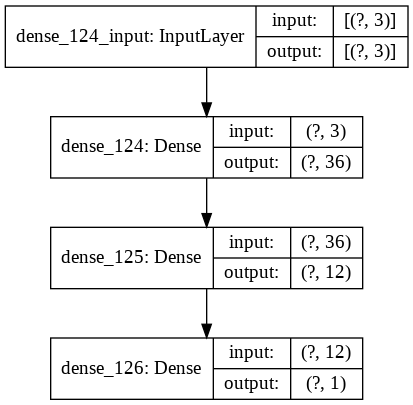

In [161]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

runs_nn_3 = Sequential()
runs_nn_3.add( Dense(36, input_dim = len(features), activation = 'relu'))
runs_nn_3.add( Dense(12, activation = 'relu' ))
runs_nn_3.add( Dense(1, activation = 'relu' ))

runs_nn_3.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
runs_nn_3.summary()
plot_model(runs_nn_3, to_file='runs_nn_3.png', show_shapes=True)

In [162]:
##Train the Model
history_nn_3 = runs_nn_3.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      verbose = 0)

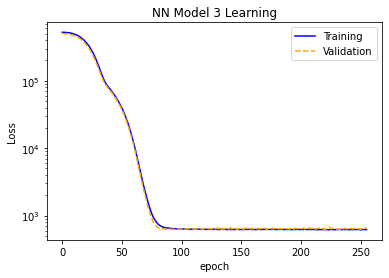

In [163]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_nn_3)
figs[1].set_title('NN Model 3 Learning')
plt.savefig('nn_3_learn_curve.png')
figs[0].show()

In [164]:
##Get the Predictions on Training and Validation
train_pred = runs_nn_3.predict(XTRAIN)
valid_pred = runs_nn_3.predict(XVALID)

nn_metrics_3 = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})
nn_metrics_3.to_csv('nn_3_metrics.csv')
nn_metrics_3.T.head()

,mse,mae,r2
train,614.267131,19.790319,0.924665
valid,636.025568,20.058687,0.928421


Define Neural Network Candidate 4

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 18)                72        
_________________________________________________________________
dense_128 (Dense)            (None, 12)                228       
_________________________________________________________________
dense_129 (Dense)            (None, 6)                 78        
_________________________________________________________________
dense_130 (Dense)            (None, 1)                 7         
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


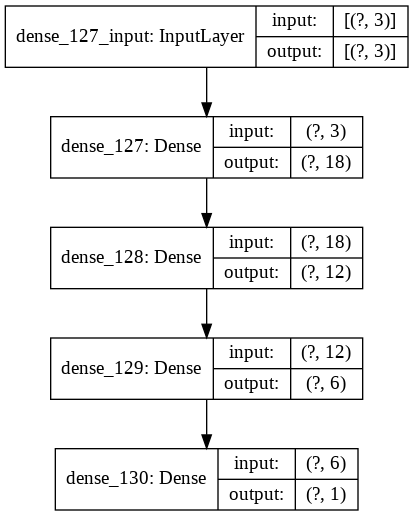

In [165]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

runs_nn_4 = Sequential()
runs_nn_4.add( Dense(18, input_dim = len(features), activation = 'relu'))
runs_nn_4.add( Dense(12, activation='relu'))
runs_nn_4.add( Dense(6, activation = 'relu' ))
runs_nn_4.add( Dense(1, activation = 'relu' ))

runs_nn_4.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
runs_nn_4.summary()
plot_model(runs_nn_4, to_file='runs_nn_4.png', show_shapes=True)

In [166]:
##Train the Model
history_nn_4 = runs_nn_4.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      verbose = 0)

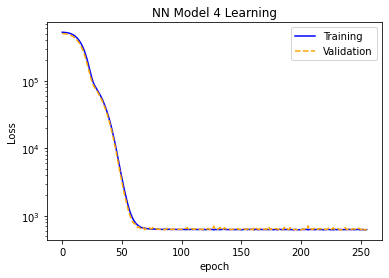

In [167]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_nn_4)
figs[1].set_title('NN Model 4 Learning')
plt.savefig('nn_4_learn_curve.png')
figs[0].show()

In [168]:
##Get the Predictions on Training and Validation
train_pred = runs_nn_4.predict(XTRAIN)
valid_pred = runs_nn_4.predict(XVALID)

nn_metrics_4 = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})
nn_metrics_4.to_csv('nn_4_metrics.csv')
nn_metrics_4.T.head()

,mse,mae,r2
train,615.693613,19.778855,0.924490
valid,620.694299,19.851042,0.930146


Define Neural Network Candidate 5

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 24)                96        
_________________________________________________________________
dense_132 (Dense)            (None, 18)                450       
_________________________________________________________________
dense_133 (Dense)            (None, 6)                 114       
_________________________________________________________________
dense_134 (Dense)            (None, 3)                 21        
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 4         
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


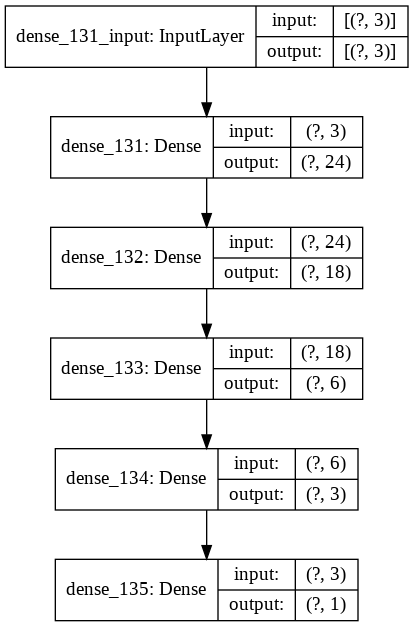

In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

runs_nn_5 = Sequential()
runs_nn_5.add( Dense(24, input_dim = len(features), activation = 'relu'))
runs_nn_5.add( Dense(18, activation = 'relu'))
runs_nn_5.add( Dense(6, activation='relu'))
runs_nn_5.add( Dense(3, activation = 'relu' ))
runs_nn_5.add( Dense(1, activation = 'relu' ))

runs_nn_5.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
runs_nn_5.summary()
plot_model(runs_nn_5, to_file='runs_nn_5.png', show_shapes=True)

In [170]:
##Train the Model
history_nn_5 = runs_nn_5.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = 2 * DEFAULT_EPOCHS,
                      verbose = 0)

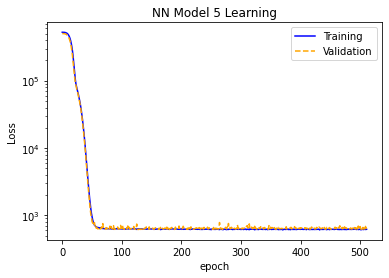

In [171]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_nn_5)
figs[1].set_title('NN Model 5 Learning')
plt.savefig('nn_5_learn_curve.png')
figs[0].show()

In [172]:
##Get the Predictions on Training and Validation
train_pred = runs_nn_5.predict(XTRAIN)
valid_pred = runs_nn_5.predict(XVALID)

nn_metrics_5 = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})
nn_metrics_5.to_csv('nn_5_metrics.csv')
nn_metrics_5.T.head()

,mse,mae,r2
train,661.575900,20.636292,0.918863
valid,655.193625,20.910995,0.926264


Define the Linear Regression Model

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


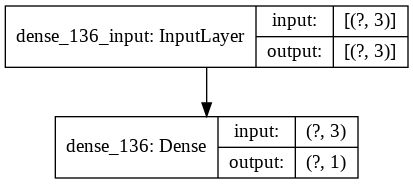

In [173]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

lin = Sequential()
lin.add( Dense(1, input_dim = len(features), activation = 'linear'))
lin.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
lin.summary()
plot_model(lin, to_file='lin.png', show_shapes=True)

In [174]:
##Train the Model
history_lin = lin.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      verbose = 0)

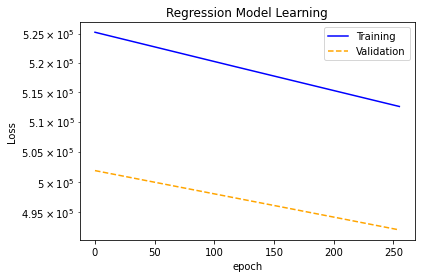

In [175]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_lin)
figs[1].set_title('Regression Model Learning')
plt.savefig('lin_learn_curve.png')
figs[0].show()

In [176]:
##Get the Predictions on Training and Validation
train_pred = lin.predict(XTRAIN)
valid_pred = lin.predict(XVALID)

lin_metrics = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
               'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})

lin_metrics.T.to_csv('nn_vs_lin.csv')
lin_metrics.T.head()

,mse,mae,r2
train,512520.325528,711.233697,-61.856308
valid,492147.050218,696.290062,-54.386833


##Performance if Incorrect Activation Utilized by Regression Model

Set Last Layer to Have Sigmoid

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 18)                72        
_________________________________________________________________
dense_60 (Dense)             (None, 6)                 114       
_________________________________________________________________
dense_61 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 4         
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


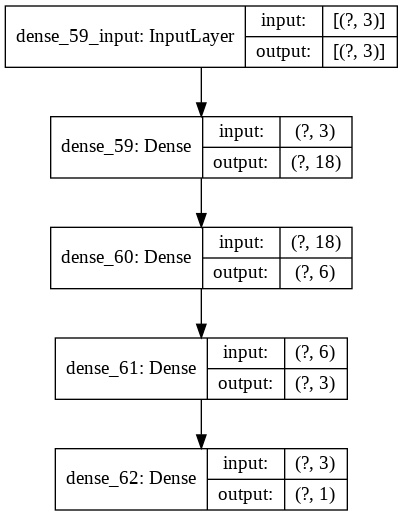

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

runs_nn_last_sig = Sequential()
runs_nn_last_sig.add( Dense(18, input_dim = len(features), activation = 'relu'))
runs_nn_last_sig.add( Dense(6, activation='relu'))
runs_nn_last_sig.add( Dense(3, activation = 'relu' ))
runs_nn_last_sig.add( Dense(1, activation = 'sigmoid' ))

runs_nn_last_sig.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
runs_nn_last_sig.summary()
plot_model(runs_nn_last_sig, to_file='runs_nn_last_sig.png', show_shapes=True)

In [92]:
##Train the Model
history_nn_last_sig = runs_nn_last_sig.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      verbose = 0)

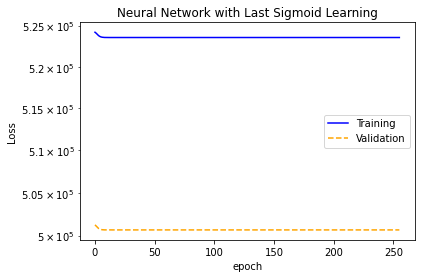

In [93]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_nn_last_sig)
figs[1].set_title('Neural Network with Last Sigmoid Learning')
plt.savefig('last_sig_learn_curve.png')
figs[0].show()

In [94]:
##Compare the results of the incorrect vs the correct last activation
train_pred = runs_nn_last_sig.predict(XTRAIN)
valid_pred = runs_nn_last_sig.predict(XVALID)

last_sig_metrics = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
               'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})

last_sig_metrics.T.to_csv('last_sig.csv')
last_sig_metrics.T.head()

,mse,mae,r2
train,523564.239451,717.920886,-63.210751
valid,500661.887324,701.267606,-55.345103


Set All Layers to Sigmoid Activations

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 18)                72        
_________________________________________________________________
dense_64 (Dense)             (None, 6)                 114       
_________________________________________________________________
dense_65 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 4         
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


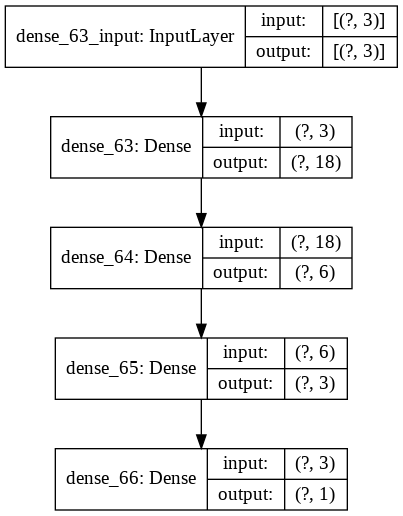

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

runs_nn_all_sig = Sequential()
runs_nn_all_sig.add( Dense(18, input_dim = len(features), activation = 'sigmoid'))
runs_nn_all_sig.add( Dense(6, activation='sigmoid'))
runs_nn_all_sig.add( Dense(3, activation = 'sigmoid' ))
runs_nn_all_sig.add( Dense(1, activation = 'sigmoid' ))

runs_nn_all_sig.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
runs_nn_all_sig.summary()
plot_model(runs_nn_all_sig, to_file='runs_nn_all_sig.png', show_shapes=True)

In [96]:
##Train the Model
history_nn_all_sig = runs_nn_all_sig.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      verbose = 0)

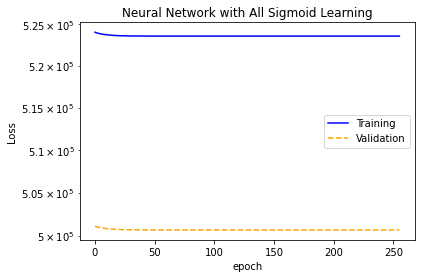

In [97]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_nn_all_sig)
figs[1].set_title('Neural Network with All Sigmoid Learning')
plt.savefig('all_sig_learn_curve.png')
figs[0].show()

In [98]:
##Compare the results of the sigmoid on regression model
train_pred = runs_nn_all_sig.predict(XTRAIN)
valid_pred = runs_nn_all_sig.predict(XVALID)

all_sig_metrics = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
               'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})

all_sig_metrics.T.to_csv('all_sig.csv')
all_sig_metrics.T.head()

,mse,mae,r2
train,523564.239451,717.920886,-63.210751
valid,500661.887324,701.267606,-55.345103


##Overfitting Model

Define the Overfitting Network

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 256)               1024      
_________________________________________________________________
dense_79 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_80 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_81 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_82 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_83 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_84 (Dense)             (None, 1)               

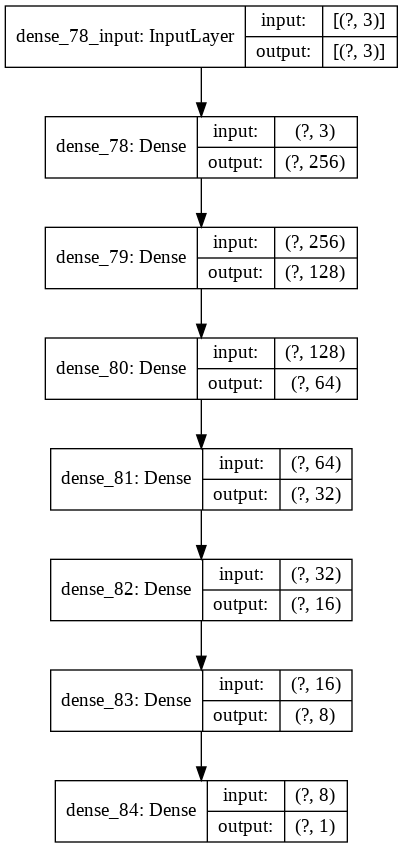

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

overfit = Sequential()
overfit.add( Dense(256, input_dim = len(features), activation = 'relu'))
overfit.add( Dense(128, activation = 'relu'))
overfit.add( Dense(64, activation= 'relu'))
overfit.add( Dense(32, activation = 'relu'))
overfit.add( Dense(16, activation = 'relu'))
overfit.add( Dense(8, activation = 'relu'))
overfit.add( Dense(1, activation = 'relu'))

overfit.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
overfit.summary()
plot_model(overfit, to_file='overfit.png', show_shapes=True)

In [114]:
##Train the Model
history_overfit = overfit.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = 8 * DEFAULT_EPOCHS,
                      verbose = 0)

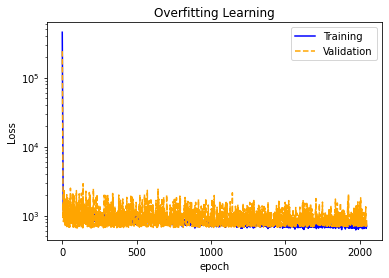

In [115]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_overfit)
figs[1].set_title('Overfitting Learning')
plt.savefig('overfit_learn_curve.png')
figs[0].show()

In [116]:
##Get the Predictions on Training and Validation
train_pred = overfit.predict(XTRAIN)
valid_pred = overfit.predict(XVALID)

overfit_metrics = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
               'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})

overfit_metrics.head().T.to_csv('overfit.csv')
overfit_metrics.head().T.head()

,mse,mae,r2
train,726.806022,21.809376,0.910863
valid,895.188144,24.488582,0.899254


##Overfitting Model: Output as Input Feature

Set the Training And Validation Data to have the Output as an Input Feature

In [103]:
##Create copies of the Training Set
XTRAIN_INPUT = np.array(TRAIN[:, :])
YTRAIN_INPUT = np.array(TRAIN[:, -1])

##Create copies of the Validation Set
XVALID_INPUT = np.array(VALID[:, :])
YVALID_INPUT = np.array(VALID[:, -1])

In [104]:
##Adjust the Training Data
mean = XTRAIN_INPUT.mean(axis = 0)
XTRAIN_INPUT -= mean
std = XTRAIN_INPUT.std(axis = 0)
XTRAIN_INPUT /= std

##Adjust the Validation Data
XVALID_INPUT -= mean
XVALID_INPUT /= std

Define the Overfitting Model with Output as Feature

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_75 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_76 (Dense)             (None, 12)                396       
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 13        
Total params: 5,177
Trainable params: 5,177
Non-trainable params: 0
_________________________________________________________________


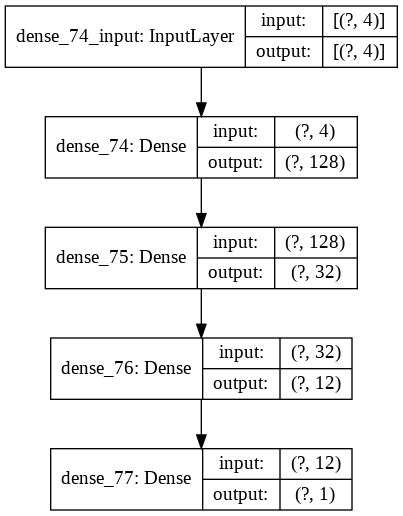

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape

overfit_input = Sequential()
overfit_input.add( Dense(128, input_dim = len( XTRAIN_INPUT[0,:] ), activation = 'relu'))
overfit_input.add( Dense(32, activation = 'relu'))
overfit_input.add( Dense(12, activation = 'relu'))
overfit_input.add( Dense(1, activation = 'relu' ))

overfit_input.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'] )
overfit_input.summary()
plot_model(overfit_input, to_file='overfit_input.png', show_shapes=True)

In [106]:
##Train the Model
history_overfit_input = overfit_input.fit( XTRAIN_INPUT, YTRAIN_INPUT,
                      validation_data = (XVALID_INPUT, YVALID_INPUT),
                      epochs = 5 * DEFAULT_EPOCHS,
                      verbose = 0)

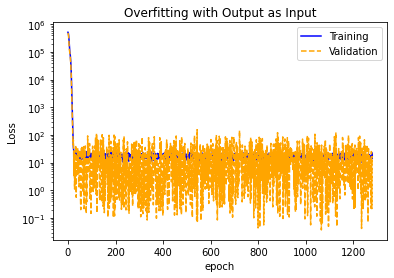

In [107]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_overfit_input)
figs[1].set_title('Overfitting with Output as Input')
plt.savefig('overfit_input_learn_curve.png')
figs[0].show()

In [108]:
##Get the Predictions on Training and Validation
train_pred = overfit_input.predict(XTRAIN_INPUT)
valid_pred = overfit_input.predict(XVALID_INPUT)

overfit_input_metrics = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN_INPUT, train_pred),
               'valid': RegEvalUtil.get_eval_metrics(YVALID_INPUT, valid_pred)})

overfit_input_metrics.T.to_csv('overfit_input.csv')
overfit_input_metrics.T.head()

,mse,mae,r2
train,14.747030,3.705721,0.998191
valid,16.250932,3.901407,0.998171


##Function to Simulate Neural Network Prediction

In [177]:
import numpy as np

class ModelSim:
  def __init__(self, model):
    self.w = []
    self.b = []
    for lay in model.layers:
      params = np.array(lay.get_weights())
      self.w.append(params[0])
      self.b.append(params[1])
  ##TODO: Update to determine shape of tensor
  def get_prediction(self, x):
    t = np.array(x)
    for i in range(len(self.w)):
      ##Broadcast and take dot product before adding bias
      t = (self.w[i] * t.reshape( len(t), 1 )).sum(axis = 0) + self.b[i]
    return t

In [178]:
model = runs_nn_1
model_sim = ModelSim(model)

##Get the predictions for the Training Set
n_train = len(XTRAIN)
sim_train_pred = np.zeros(shape=(n_train, 1))
for i in range(n_train):
  sim_train_pred[i] = model_sim.get_prediction(XTRAIN[i])

##Get the predications for the Validation Set
n_valid = len(XVALID)
sim_valid_pred = np.zeros(shape=(n_valid, 1))
for i in range(n_valid):
  sim_valid_pred[i] = model_sim.get_prediction(XVALID[i])


Compare Metrics Between the Data and the Preditions

In [179]:
##Get the metrics by comparing those of the true data
sim_metrics_data = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, sim_train_pred),
               'valid': RegEvalUtil.get_eval_metrics(YVALID, sim_valid_pred)})

sim_metrics_data.to_csv('sim_metrics_data.csv')
sim_metrics_data.T.head()

,mse,mae,r2
train,633.666777,20.139966,0.922286
valid,663.404513,20.209291,0.925340


In [180]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

sim_metrics_model = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(train_pred, sim_train_pred),
              'valid': RegEvalUtil.get_eval_metrics(valid_pred, sim_valid_pred)})
sim_metrics_model.to_csv('sim_metrics_model.csv')
sim_metrics_model.T.head()

,mse,mae,r2
train,30.009754,4.520233,0.996018
valid,24.181091,4.179563,0.996874


##Download Information For Report

In [55]:
!rm -rf ./resources/
!mkdir ./resources

In [181]:
!mv *.csv ./resources
!mv *.png ./resources

In [182]:
!tar -cvf phase2.tar ./resources

./resources/
./resources/nn_5_learn_curve.png
./resources/Baseball.csv
./resources/nn_3_metrics.csv
./resources/runs_nn_4.png
./resources/all_sig_learn_curve.png
./resources/runs_nn_1.png
./resources/last_sig.csv
./resources/overfit_learn_curve.png
./resources/lin_learn_curve.png
./resources/overfit_input.csv
./resources/nn_4_metrics.csv
./resources/nn_2_metrics.csv
./resources/sim_metrics_data.csv
./resources/nn_1_learn_curve.png
./resources/last_sig_learn_curve.png
./resources/runs_nn_last_sig.png
./resources/overfit_input_learn_curve.png
./resources/overfit.csv
./resources/all_sig.csv
./resources/nn_1_metrics.csv
./resources/nn_5_metrics.csv
./resources/nn_3_learn_curve.png
./resources/runs_nn_all_sig.png
./resources/runs_nn_3.png
./resources/runs_nn_5.png
./resources/nn_4_learn_curve.png
./resources/nn_2_learn_curve.png
./resources/lin.png
./resources/nn_vs_lin.csv
./resources/overfit_input.png
./resources/overfit.png
./resources/sim_metrics_model.csv
./resources/runs_nn_2.png


In [183]:
from google.colab import files
files.download('phase2.tar')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>